In [1]:
%matplotlib inline

In [2]:
import os
import yaml
import shutil
from tqdm import tqdm
from datetime import datetime
import random
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [2]:
!pip install -U ultralytics roboflow ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 14.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
jupyterlab 4.2.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible

In [3]:
from ultralytics import YOLO
model = YOLO("yolov5l.pt")

PRO TIP 💡 Replace 'model=yolov5l.pt' with new 'model=yolov5lu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [4]:
from roboflow import Roboflow

# dataset from https://universe.roboflow.com/great-barrier-reef/great-barrier-reef-o5scc
ROBOFLOW_API_KEY = "rWU1eQHaSgCK3DzRY2TP"
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("great-barrier-reef").project("great-barrier-reef-o5scc")
dataset = project.version(5).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Great-Barrier-Reef-5 in yolov5pytorch:: 100%|██████████| 9838/9838 [00:01<00:00, 7729.51it/s]


In [4]:
HOME = os.getcwd()

In [6]:
!mkdir datasets/ 
!mv {HOME}/Great-Barrier-Reef-5 datasets/

In [5]:
# replace class 'json' to 'starfish' in data.yaml
DATASET_PATH = f'{HOME}/datasets/Great-Barrier-Reef-5/'

with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['names'] = ['starfish']
data['train'] = DATASET_PATH + 'train/images'
data['val'] = DATASET_PATH + 'valid/images'
data['test'] = DATASET_PATH +'test/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [6]:
DATASET_PATH = f'{HOME}/datasets/Great-Barrier-Reef-5/'

In [10]:
os.environ['WANDB_DISABLED'] = 'true'
os.environ['WANDB_MODE'] = 'disabled'

In [8]:
# Define the source and destination directories
source_image_dir = DATASET_PATH + 'train/images'
source_label_dir = DATASET_PATH + 'train/labels'
destination_image_dir = DATASET_PATH + 'sub_train/images'
destination_label_dir = DATASET_PATH + 'sub_train/labels'

# Create the destination directory if it does not exist
os.mkdir(DATASET_PATH + 'sub_train')
os.mkdir(destination_image_dir)
os.mkdir(destination_label_dir)

# List all files in the source directory
train_images = os.listdir(source_image_dir)

# Calculate the number of images to copy (3/4 of the total images)
num_images_to_copy = len(train_images) * 3 // 4

# Randomly select 3/4 of the images
images_to_copy = random.sample(train_images, num_images_to_copy)

# Copy the selected images to the destination directory
for image in images_to_copy:
    source_image_path = os.path.join(source_image_dir, image)
    source_label_path = source_image_path.replace("images", "labels").replace(".jpg", ".txt")
    
    destination_image_path = os.path.join(destination_image_dir, image)
    destination_label_path = destination_image_path.replace("images", "labels").replace(".jpg", ".txt")
    
    shutil.copy(source_image_path, destination_image_path)
    shutil.copy(source_label_path, destination_label_path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'h:\\python_projects\\deep_learning_technion\\project\\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/sub_train'

In [9]:
# replace destination for training from "train" to 'sub_train' in data.yaml
DATASET_PATH = f'{HOME}/datasets/Great-Barrier-Reef-5/'

with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['train'] = DATASET_PATH + 'sub_train/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [10]:
import optuna
import subprocess
import yaml
import os

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 0.0005, 0.05, log=True)
    momentum = trial.suggest_float("momentum", 0.7, 0.95)
    disabled_aug = {'augment': False,
                    'hsv_h': 0,
                    'hsv_s': 0,
                    'hsv_v': 0,
                    'degrees': 0,
                    'translate': 0,
                    'scale': 0,
                    'shear': 0,
                    'perspective': 0,
                    'flipud': 0,
                    'fliplr': 0,
                    'mosaic': 0,
                    'mixup': 0,
                    'erasing': 0.0,
                    'crop_fraction':0.0,
                   }
    
    
    model = YOLO("yolov5n.pt")    
        
    results = model.train(data=DATASET_PATH + 'data.yaml',
                            epochs=20,
                            plots=True,
                            imgsz=640,
                            batch=16,
                            lr0=learning_rate,
                            momentum=momentum,
                            optimizer="Adam",
                            patience=0,
                            **disabled_aug,
                            )
        
    metrics = model.val(data=DATASET_PATH + 'data.yaml')
    fitness = 0.2 * metrics.results_dict['metrics/recall(B)'] + 0.2 * metrics.results_dict['metrics/mAP50(B)'] + 0.6 * metrics.results_dict['metrics/mAP50-95(B)'] 
    val_loss = fitness # Run validation on a set specified as 'val' argument
    
    return val_loss

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-08-16 15:41:21,446] A new study created in memory with name: no-name-9a1d489a-204b-4560-89cf-3eeb04105424


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fals

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: Adam(lr=0.00261417583311359, momentum=0.7953925460823533) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/162 [00:00<?, ?it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/20      2.28G      2.371       3.15      1.543          3        640: 100%|██████████| 162/162 [00:47<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/31 [00:00<?, ?it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED 

                   all        983       2479      0.311     0.0584     0.0565     0.0222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G      1.871      1.748       1.28          2        640: 100%|██████████| 162/162 [00:41<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.42it/s]

                   all        983       2479      0.383      0.249      0.223     0.0928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.712      1.284      1.203          8        640: 100%|██████████| 162/162 [00:41<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.632      0.243      0.276      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.576      1.026      1.147         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.12it/s]


                   all        983       2479      0.703      0.522      0.575      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.31G      1.459     0.8955      1.095          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.14it/s]

                   all        983       2479      0.723      0.421      0.508       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.373     0.7991      1.068          2        640: 100%|██████████| 162/162 [00:42<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.09it/s]

                   all        983       2479      0.692      0.374       0.43      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.301      0.725      1.039          5        640: 100%|██████████| 162/162 [00:42<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.05it/s]

                   all        983       2479      0.847       0.56      0.639      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G      1.201     0.6483     0.9989          3        640: 100%|██████████| 162/162 [00:42<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.771      0.599      0.692      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.143     0.6014     0.9794          5        640: 100%|██████████| 162/162 [00:42<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.06it/s]

                   all        983       2479      0.673      0.403       0.52      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      1.058     0.5582     0.9472          2        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.07it/s]

                   all        983       2479      0.772      0.638      0.741      0.428


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G     0.9925     0.5291     0.9298          2        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.10it/s]

                   all        983       2479      0.767      0.666      0.759      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G     0.9206     0.4941     0.9055          3        640: 100%|██████████| 162/162 [00:42<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.07it/s]

                   all        983       2479       0.77      0.691      0.772      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G     0.8584     0.4596     0.8864          3        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.06it/s]

                   all        983       2479      0.804      0.663      0.756      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G     0.8001     0.4363     0.8722          2        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.06it/s]

                   all        983       2479      0.924      0.785      0.883      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G     0.7401     0.4122     0.8567         20        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.878      0.743      0.844      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G      0.669      0.385     0.8405          2        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.937      0.783       0.88      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G     0.6147     0.3636     0.8286          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]

                   all        983       2479      0.915      0.753       0.86      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G     0.5569      0.341     0.8176          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]

                   all        983       2479       0.91      0.823      0.898      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.4983     0.3181     0.8078         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.902      0.811      0.889      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.4431     0.2989     0.7988          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]

                   all        983       2479      0.875      0.821      0.889      0.558



20 epochs completed in 0.315 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


                   all        983       2479      0.912      0.823      0.899      0.564
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/62 [00:00<?, ?it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.94it/s]


                   all        983       2479      0.912      0.823      0.899      0.564
Speed: 0.3ms preprocess, 3.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train2


[I 2024-08-16 16:02:40,444] Trial 0 finished with value: 0.6829511934836432 and parameters: {'learning_rate': 0.00261417583311359, 'momentum': 0.7953925460823533}. Best is trial 0 with value: 0.6829511934836432.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fal

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: Adam(lr=0.02154742228346919, momentum=0.746758890911706) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.476      3.308       1.61          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.17it/s]


                   all        983       2479      0.019     0.0339    0.00348    0.00121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.32G       2.21      2.669      1.457          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.07it/s]


                   all        983       2479     0.0304      0.027    0.00999    0.00578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.31G      2.128      2.429       1.41          8        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


                   all        983       2479      0.291      0.148      0.126     0.0501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.981      2.103      1.347         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


                   all        983       2479        0.1      0.103     0.0373      0.014

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.854      1.829      1.281          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]


                   all        983       2479       0.22      0.161      0.116     0.0508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.757      1.599       1.24          2        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.05it/s]

                   all        983       2479      0.107     0.0742      0.036     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.681      1.417       1.21          5        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


                   all        983       2479      0.528      0.244      0.266      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.32G      1.593      1.244      1.168          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]


                   all        983       2479      0.358      0.194      0.203        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.529      1.129      1.142          5        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.427      0.154      0.167     0.0813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      1.438     0.9992      1.105          2        640: 100%|██████████| 162/162 [00:44<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.506      0.268      0.301      0.151


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G      1.403     0.9178       1.09          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.746      0.499      0.599      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G      1.342     0.8399      1.064          3        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.648      0.234      0.319      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G      1.275     0.7859      1.041          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.872      0.512      0.582      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G      1.226     0.7156      1.024          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.714      0.503      0.611      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G       1.17     0.6689      1.006         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.782       0.54       0.64      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G      1.087     0.6183     0.9819          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        983       2479      0.802      0.567      0.686      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G      1.038     0.5769     0.9626          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.763      0.519      0.626      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G     0.9693     0.5393     0.9412          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.807      0.597      0.721      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.8927     0.5018     0.9194         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.748      0.532      0.629      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.8233     0.4659     0.8991          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.769      0.587      0.697      0.411



20 epochs completed in 0.318 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 5.3MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


                   all        983       2479      0.808      0.597      0.721      0.413
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train3
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.83it/s]


                   all        983       2479      0.808      0.597      0.721      0.413
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train32


[I 2024-08-16 16:25:09,356] Trial 1 finished with value: 0.5112440654788395 and parameters: {'learning_rate': 0.02154742228346919, 'momentum': 0.746758890911706}. Best is trial 0 with value: 0.6829511934836432.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fal

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: Adam(lr=0.001224477345171951, momentum=0.9337245680623043) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.425      3.355      1.572          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.16it/s]

                   all        983       2479      0.172        0.1     0.0783     0.0361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.32G      1.891       1.88      1.283          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]


                   all        983       2479      0.394      0.276      0.261      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G       1.69      1.266      1.188          8        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.08it/s]

                   all        983       2479      0.667      0.464      0.525      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.3G      1.517      1.011      1.116         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]

                   all        983       2479      0.723      0.558      0.622      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.29G      1.408     0.8469      1.071          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.697      0.574      0.617      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.307     0.7591      1.034          2        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.841      0.648       0.75      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G       1.23      0.684      1.006          5        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.786      0.616      0.704      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.137      0.622     0.9705          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        983       2479      0.649      0.581      0.599      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.055     0.5758     0.9451          5        640: 100%|██████████| 162/162 [00:44<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.64it/s]

                   all        983       2479      0.888      0.706      0.804      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.29G     0.9878     0.5331     0.9237          2        640: 100%|██████████| 162/162 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]

                   all        983       2479      0.902      0.751       0.85      0.488


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.9228     0.5027     0.9027          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479        0.9      0.781      0.865      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.29G      0.852     0.4652     0.8832          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.05it/s]

                   all        983       2479      0.891      0.751      0.854      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.7926     0.4433     0.8686          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.911      0.775      0.872      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.29G       0.74     0.4181     0.8551          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.936      0.764      0.881      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.6798     0.3943     0.8412         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.907      0.807       0.89      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.29G     0.6173     0.3672      0.828          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.944      0.787      0.896      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.5701     0.3512     0.8184          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]

                   all        983       2479      0.905      0.818      0.898      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.29G      0.527      0.332     0.8112          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]

                   all        983       2479       0.92      0.802      0.902       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.4662     0.3112     0.8027         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]

                   all        983       2479      0.936      0.796      0.903      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4211     0.2946     0.7955          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]

                   all        983       2479      0.912      0.827      0.907       0.57



20 epochs completed in 0.338 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 5.3MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.60it/s]


                   all        983       2479      0.912      0.826      0.907       0.57
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train4
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  5.06it/s]


                   all        983       2479      0.912      0.826      0.907       0.57
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train42


[I 2024-08-16 16:47:48,788] Trial 2 finished with value: 0.6882853516367786 and parameters: {'learning_rate': 0.001224477345171951, 'momentum': 0.9337245680623043}. Best is trial 2 with value: 0.6882853516367786.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fal

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train5\labels.jpg... 
optimizer: Adam(lr=0.008646717757863012, momentum=0.9389247989447047) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.399      3.177      1.561          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.08it/s]


                   all        983       2479      0.246      0.154       0.11     0.0377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G      1.998      2.131      1.348          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


                   all        983       2479      0.392      0.217      0.199     0.0705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.863      1.764       1.28          8        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


                   all        983       2479      0.137       0.11     0.0621     0.0277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.718      1.439      1.214         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


                   all        983       2479      0.317      0.201      0.167     0.0756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.628      1.218      1.174          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


                   all        983       2479      0.564      0.221      0.253      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.533       1.06       1.14          2        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


                   all        983       2479      0.523      0.399      0.398      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G       1.49       0.94       1.12          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]


                   all        983       2479      0.348      0.342      0.242      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.403     0.8397      1.082          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.754      0.551      0.639      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.351     0.7711      1.064          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.801      0.624      0.696      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.261     0.7069      1.032          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


                   all        983       2479      0.779       0.63      0.704      0.387
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G      1.212     0.6619      1.018          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        983       2479      0.799      0.549      0.652      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G      1.137     0.6206     0.9847          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.727      0.642      0.677      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G      1.104     0.5842     0.9733          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.797      0.671      0.753      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G       1.04     0.5486     0.9537          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.874      0.664      0.793      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.9729      0.522     0.9327         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.814      0.669      0.759      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G      0.921     0.4967     0.9155          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.853      0.733      0.812      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.8478     0.4628     0.8943          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.849       0.71      0.809      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.7821     0.4334     0.8771          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.881      0.708      0.813      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G      0.711     0.4022     0.8598         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.878      0.775       0.86      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.6487     0.3803     0.8447          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        983       2479      0.902      0.785      0.873       0.53



20 epochs completed in 0.320 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 5.3MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


                   all        983       2479      0.901      0.786      0.873       0.53
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train5
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:13<00:00,  4.75it/s]


                   all        983       2479      0.901      0.786      0.873       0.53
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train52


[I 2024-08-16 17:10:25,175] Trial 3 finished with value: 0.6496199634488722 and parameters: {'learning_rate': 0.008646717757863012, 'momentum': 0.9389247989447047}. Best is trial 2 with value: 0.6882853516367786.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fal

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: Adam(lr=0.007783342451987332, momentum=0.7445294321154543) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.27G      2.356      3.089      1.537          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]


                   all        983       2479      0.334      0.219      0.186     0.0635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G      2.006      2.123      1.355          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


                   all        983       2479     0.0959     0.0956     0.0384     0.0137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.905      1.817      1.299          8        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.30it/s]


                   all        983       2479      0.059     0.0726     0.0227     0.0108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.772      1.452      1.239         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


                   all        983       2479      0.622      0.327      0.366       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.662      1.228       1.19          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


                   all        983       2479      0.573      0.401      0.428        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.563      1.041       1.15          2        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]


                   all        983       2479      0.272      0.192      0.185     0.0934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.494       0.93      1.122          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


                   all        983       2479      0.329      0.241      0.222      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G      1.407     0.8207      1.079          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.821      0.582      0.698      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.334     0.7486      1.057          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.87it/s]

                   all        983       2479      0.652      0.522       0.58      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.254     0.6839      1.027          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


                   all        983       2479      0.789      0.414      0.495      0.275
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G       1.21      0.651      1.008          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.759       0.49      0.619      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G      1.133     0.5967     0.9782          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.597      0.465      0.514      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G      1.063     0.5562     0.9582          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.745      0.624      0.735      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G      1.003      0.536     0.9413          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.829       0.65      0.758      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.9379     0.4963     0.9198         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.826      0.692      0.796      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.8718     0.4735     0.9004          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.861      0.738       0.84      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.8134     0.4441     0.8814          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.854      0.715      0.819       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.7394     0.4139     0.8637          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.867      0.738      0.828      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.6626     0.3866     0.8463         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.833      0.731      0.827      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G      0.601     0.3651     0.8328          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.911      0.733      0.846       0.52



20 epochs completed in 0.320 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 5.3MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.46it/s]


                   all        983       2479      0.912      0.732      0.846      0.519
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train6
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.85it/s]


                   all        983       2479      0.912      0.732      0.846      0.519
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train62


[I 2024-08-16 17:33:02,428] Trial 4 finished with value: 0.6271729368936565 and parameters: {'learning_rate': 0.007783342451987332, 'momentum': 0.7445294321154543}. Best is trial 2 with value: 0.6882853516367786.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fal

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: Adam(lr=0.02866140560327309, momentum=0.9324449359485177) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train7
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.501       3.33      1.629          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


                   all        983       2479   0.000149     0.0177   7.59e-05   3.23e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.32G      2.208      2.647      1.461          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.29it/s]


                   all        983       2479     0.0207     0.0787      0.013    0.00698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.31G      2.093      2.401      1.402          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.30it/s]


                   all        983       2479      0.304      0.186      0.155     0.0625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.934       2.13      1.324         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


                   all        983       2479      0.177      0.146     0.0905     0.0337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.882      1.987      1.301          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.05it/s]

                   all        983       2479      0.137      0.163     0.0795     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.796      1.816      1.261          2        640: 100%|██████████| 162/162 [00:44<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.71it/s]


                   all        983       2479      0.379       0.23      0.204     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.713      1.624      1.226          5        640: 100%|██████████| 162/162 [00:45<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


                   all        983       2479      0.123      0.213     0.0707     0.0327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.32G      1.652      1.455      1.194          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


                   all        983       2479      0.486      0.254      0.281      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.592      1.298       1.17          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.313      0.208      0.192     0.0927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G       1.51      1.158      1.133          2        640: 100%|██████████| 162/162 [00:44<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


                   all        983       2479      0.613      0.253      0.268      0.128
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G      1.465      1.084      1.117          2        640: 100%|██████████| 162/162 [00:45<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]

                   all        983       2479      0.342      0.142      0.152     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G      1.396     0.9859      1.089          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


                   all        983       2479       0.59      0.332      0.353       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G      1.341      0.883      1.066          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


                   all        983       2479      0.578      0.264      0.295      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G      1.282     0.8262      1.048          2        640: 100%|██████████| 162/162 [00:50<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.48it/s]

                   all        983       2479      0.802      0.347      0.413      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G      1.232     0.7688       1.03         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.402      0.479      0.296      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G      1.163     0.7092      1.009          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.805      0.527      0.627      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G      1.108     0.6651     0.9863          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.771      0.424      0.503      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G       1.03        0.6     0.9623          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]

                   all        983       2479      0.819      0.574      0.685      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.9716     0.5647     0.9436         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.622      0.471      0.542      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.9132     0.5247     0.9245          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        983       2479      0.781      0.539      0.641      0.364



20 epochs completed in 0.335 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 5.3MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


                   all        983       2479      0.818      0.574      0.685      0.379
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train7
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:13<00:00,  4.64it/s]


                   all        983       2479      0.818      0.574      0.685      0.379
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\train72


[I 2024-08-16 17:56:31,365] Trial 5 finished with value: 0.47915310618888773 and parameters: {'learning_rate': 0.02866140560327309, 'momentum': 0.9324449359485177}. Best is trial 2 with value: 0.6882853516367786.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fal

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: Adam(lr=0.0025471226291089786, momentum=0.7157605069100088) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G       2.38      3.189      1.546          3        640: 100%|██████████| 162/162 [00:46<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.08it/s]

                   all        983       2479      0.234       0.05     0.0525     0.0225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.33G      1.894      1.846      1.294          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


                   all        983       2479      0.519      0.313      0.334      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.745      1.355      1.212          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]


                   all        983       2479      0.671       0.47      0.536      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.609      1.087      1.159         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]


                   all        983       2479       0.48      0.335      0.335      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.493     0.9229       1.11          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.751      0.511      0.601      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.387     0.7959      1.071          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.797      0.616      0.714      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.317      0.736      1.042          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.845      0.685      0.767      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.223     0.6606      1.008          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.857      0.676      0.778      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.146     0.6094     0.9784          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.87it/s]

                   all        983       2479      0.872      0.601      0.722      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.069     0.5651      0.954          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.859       0.71      0.812      0.457


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G      1.006     0.5237     0.9334          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.905      0.782      0.863      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.9363     0.4929      0.909          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        983       2479      0.865      0.763      0.848      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.8664     0.4598     0.8886          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.907      0.749       0.87      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G     0.8005     0.4353     0.8721          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]

                   all        983       2479      0.874      0.744      0.847      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.7435     0.4121     0.8567         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479       0.93      0.793      0.892      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.6785     0.3848     0.8421          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479        0.9      0.811      0.896      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.6256     0.3637     0.8292          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.935      0.802      0.901      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.5649     0.3423     0.8176          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.922      0.814      0.904      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.5031     0.3196     0.8072         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.922      0.825      0.911      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4442     0.2978     0.7982          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.919       0.83      0.911      0.576



20 epochs completed in 0.322 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 5.3MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


                   all        983       2479      0.919      0.829      0.911      0.576
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train8
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.87it/s]


                   all        983       2479      0.919      0.829      0.911      0.576
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train82


[I 2024-08-16 18:19:09,870] Trial 6 finished with value: 0.6935803521506649 and parameters: {'learning_rate': 0.0025471226291089786, 'momentum': 0.7157605069100088}. Best is trial 6 with value: 0.6935803521506649.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fal

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: Adam(lr=0.011316954182901047, momentum=0.7526124714829736) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train9
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.383      3.098      1.563          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


                   all        983       2479      0.236      0.152      0.106      0.042

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.34G      2.048      2.229      1.381          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


                   all        983       2479      0.153      0.141     0.0732     0.0314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.935      1.937      1.322          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.47it/s]


                   all        983       2479      0.179      0.127     0.0827     0.0322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.791      1.563      1.259         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


                   all        983       2479      0.398      0.319      0.283      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.688      1.319      1.208          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.267      0.169      0.139     0.0612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.593      1.135      1.169          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]


                   all        983       2479      0.205      0.105     0.0738     0.0276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.525      1.003       1.14          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.728       0.51      0.586       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.431     0.8831        1.1          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.708      0.542      0.614      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.376     0.7957      1.074          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.615      0.467      0.549      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.297     0.7312      1.045          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.759      0.491      0.596       0.31


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G      1.246     0.6773       1.03          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.802      0.636      0.725      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G      1.179     0.6359      1.002          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.816      0.657      0.765      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G      1.123     0.5955      0.982          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.837      0.715      0.811      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G      1.057     0.5511     0.9619          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.863      0.775       0.85      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.9833     0.5141     0.9383         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        983       2479      0.841      0.701      0.794      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.29G     0.9217     0.4898     0.9188          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]

                   all        983       2479      0.873      0.765      0.846      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.8676     0.4629      0.903          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]

                   all        983       2479      0.918      0.759      0.856      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.29G     0.7903     0.4286      0.881          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.907      0.778      0.875      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.7188     0.4012     0.8635         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.898      0.794      0.878      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G      0.643     0.3738     0.8461          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.893      0.809      0.882      0.535



20 epochs completed in 0.338 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 5.3MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


                   all        983       2479      0.894      0.808      0.882      0.535
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train9
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.90it/s]


                   all        983       2479      0.894      0.808      0.882      0.535
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train92


[I 2024-08-16 18:41:51,314] Trial 7 finished with value: 0.6587437605085685 and parameters: {'learning_rate': 0.011316954182901047, 'momentum': 0.7526124714829736}. Best is trial 6 with value: 0.6935803521506649.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: Adam(lr=0.0038603251529483844, momentum=0.8370169118618407) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train10
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.31G      2.355      3.097      1.536          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.09it/s]


                   all        983       2479      0.338      0.227      0.184     0.0766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.3G      1.887      1.817      1.288          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


                   all        983       2479      0.432      0.318      0.289       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.761      1.403      1.224          8        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]


                   all        983       2479      0.313      0.192      0.157     0.0726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.614       1.11      1.164         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


                   all        983       2479      0.622      0.392      0.407      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.506     0.9506      1.122          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


                   all        983       2479      0.517      0.386      0.395      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.421     0.8471      1.086          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.563      0.317      0.363      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.346     0.7603      1.059          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.747      0.458      0.537       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.278     0.6873      1.027          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.84it/s]

                   all        983       2479      0.825      0.637      0.748      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.185     0.6353     0.9962          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.843      0.647      0.755      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.125       0.59     0.9708          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.877      0.731      0.822      0.445


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G      1.047       0.55     0.9507          2        640: 100%|██████████| 162/162 [00:46<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.60it/s]

                   all        983       2479      0.861      0.737      0.829      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.9895     0.5212      0.926          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.843      0.671      0.763      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.9247     0.4865     0.9081          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.813      0.696      0.775       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G     0.8576     0.4611     0.8885          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.907      0.764      0.857      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.7928     0.4336     0.8725         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.916      0.775      0.875      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.7385     0.4115     0.8569          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.893      0.775      0.864      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.6718     0.3855      0.843          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.913      0.809      0.892      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.29G     0.6093     0.3624     0.8285          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.918      0.811      0.895      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.5461     0.3383     0.8165         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.896      0.802      0.878      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4828     0.3145     0.8057          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.907      0.781      0.869      0.541



20 epochs completed in 0.322 hours.
Optimizer stripped from runs\detect\train10\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train10\weights\best.pt, 5.3MB

Validating runs\detect\train10\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


                   all        983       2479       0.92      0.811      0.895      0.557
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train10
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.93it/s]


                   all        983       2479       0.92      0.811      0.895      0.557
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train102


[I 2024-08-16 19:04:36,808] Trial 8 finished with value: 0.6754121505210637 and parameters: {'learning_rate': 0.0038603251529483844, 'momentum': 0.8370169118618407}. Best is trial 6 with value: 0.6935803521506649.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train11\labels.jpg... 
optimizer: Adam(lr=0.002190904718857422, momentum=0.7573174462292723) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train11
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G       2.37      3.171      1.536          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.23it/s]

                   all        983       2479     0.0852      0.242      0.119     0.0497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.33G      1.878       1.79      1.279          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]


                   all        983       2479       0.54      0.329       0.35      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.31G       1.72      1.293      1.202          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.486       0.36      0.365       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.579      1.024      1.144         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.694      0.457      0.535      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.29G       1.46     0.8794      1.095          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


                   all        983       2479      0.787      0.633      0.722       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.358     0.7749      1.058          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.695      0.559      0.642      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.296     0.7103      1.033          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.744      0.587       0.66      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G      1.201     0.6399     0.9966          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.768      0.642      0.713      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.128     0.5972     0.9691          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.856      0.587      0.694      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      1.046     0.5556      0.942          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.878      0.735       0.83      0.471


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.9855     0.5143     0.9248          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.921       0.75      0.839      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G     0.9067     0.4867     0.8986          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]

                   all        983       2479      0.873      0.773      0.851      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.8374     0.4566     0.8791          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.905       0.79      0.884      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G     0.7778     0.4296     0.8645          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.911      0.804      0.895      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.7188     0.4082      0.849         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.887       0.75      0.856      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G     0.6573     0.3798      0.837          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.924      0.811      0.908      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.6022     0.3579     0.8246          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.949       0.81      0.918      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G     0.5405     0.3358      0.813          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.939      0.836      0.924      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.4842     0.3141     0.8045         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479       0.93      0.843      0.928      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G      0.429     0.2937     0.7954          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.944      0.827      0.925      0.589



20 epochs completed in 0.320 hours.
Optimizer stripped from runs\detect\train11\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train11\weights\best.pt, 5.3MB

Validating runs\detect\train11\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


                   all        983       2479      0.943      0.827      0.926      0.589
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train11
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.88it/s]


                   all        983       2479      0.943      0.827      0.926      0.589
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train112


[I 2024-08-16 19:27:10,909] Trial 9 finished with value: 0.7039710100898018 and parameters: {'learning_rate': 0.002190904718857422, 'momentum': 0.7573174462292723}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train12\labels.jpg... 
optimizer: Adam(lr=0.0005059814703452664, momentum=0.8473469546739033) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train12
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.31G       2.45      3.474      1.569          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.19it/s]

                   all        983       2479      0.024      0.305     0.0426     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.3G      1.922       2.08      1.283          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.06it/s]

                   all        983       2479      0.335      0.188      0.171     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.706      1.417      1.179          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.668      0.468      0.536      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.515      1.054      1.103         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.696      0.491      0.557      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.384     0.8756      1.053          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]

                   all        983       2479       0.75      0.436      0.533      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.293     0.7823      1.018          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.798      0.625      0.702      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.188     0.6924     0.9821          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.871      0.662      0.762      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.102     0.6316     0.9524          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]

                   all        983       2479      0.858      0.679       0.78      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.014      0.577     0.9257          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.874      0.683       0.79      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G     0.9469     0.5418     0.9063          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.893       0.69      0.812       0.46


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.8893     0.5138     0.8886          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.864      0.707      0.816      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.8206     0.4846     0.8687          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]

                   all        983       2479       0.89      0.691      0.809      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.7683     0.4571     0.8561          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.908       0.71      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G      0.707     0.4327     0.8453          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.878      0.729      0.845      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G     0.6703     0.4159     0.8363         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.897      0.745      0.854      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.6258     0.3956     0.8272          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.933      0.754       0.87      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.5772      0.377     0.8186          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.889      0.772      0.865       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.5289     0.3585     0.8101          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        983       2479      0.911      0.767      0.878      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.4792     0.3415     0.8038         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.905      0.775      0.875      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4466     0.3293     0.7984          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479       0.89      0.772      0.875      0.529



20 epochs completed in 0.320 hours.
Optimizer stripped from runs\detect\train12\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train12\weights\best.pt, 5.3MB

Validating runs\detect\train12\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


                   all        983       2479       0.89      0.772      0.875      0.529
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train12
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.90it/s]


                   all        983       2479       0.89      0.772      0.875      0.529
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train122


[I 2024-08-16 19:49:47,927] Trial 10 finished with value: 0.646548412769639 and parameters: {'learning_rate': 0.0005059814703452664, 'momentum': 0.8473469546739033}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train13\labels.jpg... 
optimizer: Adam(lr=0.0017427323483009977, momentum=0.700377500807251) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train13
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.366      3.178      1.535          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.16it/s]

                   all        983       2479      0.325     0.0541     0.0612      0.026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.33G      1.874      1.752      1.276          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.09it/s]

                   all        983       2479      0.546      0.239       0.28      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.702      1.267      1.196          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.06it/s]

                   all        983       2479       0.59       0.35      0.394      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.562     0.9984      1.135         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.791      0.595      0.695       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G       1.44     0.8641      1.083          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.776       0.52      0.618      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.345      0.767       1.05          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.662      0.513       0.56      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.279     0.7008      1.025          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.779      0.638      0.714      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G      1.174     0.6202     0.9863          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.849      0.663      0.756      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.094      0.579     0.9586          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.877      0.665      0.784      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      1.011     0.5319     0.9307          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.875      0.744      0.838      0.478


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.9354     0.4991     0.9098          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.861      0.698      0.786      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G     0.8818      0.473     0.8916          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.911      0.769      0.864      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.8101     0.4421     0.8719          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479        0.9      0.741      0.858      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G      0.744     0.4147     0.8564          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.913      0.773      0.881       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.6898     0.3915     0.8438         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.83it/s]

                   all        983       2479      0.932      0.799      0.901      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G     0.6292     0.3684     0.8303          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479       0.94      0.801      0.904      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G      0.581     0.3468     0.8197          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.922      0.809      0.905      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G      0.515     0.3253     0.8083          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479       0.93      0.826      0.915      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G      0.461     0.3043     0.8003         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.948      0.805      0.903      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.4106     0.2865     0.7928          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.926      0.835      0.909      0.581



20 epochs completed in 0.337 hours.
Optimizer stripped from runs\detect\train13\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train13\weights\best.pt, 5.3MB

Validating runs\detect\train13\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


                   all        983       2479      0.929      0.826      0.915      0.583
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train13
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.91it/s]


                   all        983       2479      0.929      0.826      0.915      0.583
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train132


[I 2024-08-16 20:12:26,295] Trial 11 finished with value: 0.6982062978419068 and parameters: {'learning_rate': 0.0017427323483009977, 'momentum': 0.700377500807251}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train14\labels.jpg... 
optimizer: Adam(lr=0.0011262128221641418, momentum=0.7087007822398743) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train14
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G       2.41      3.306      1.554          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.18it/s]

                   all        983       2479      0.232     0.0738     0.0615     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.3G      1.889      1.877      1.276          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]


                   all        983       2479      0.449      0.208      0.232      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.707      1.315      1.189          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        983       2479      0.563       0.39      0.434      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.543          1       1.12         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.792      0.616      0.702      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.409      0.846      1.069          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]


                   all        983       2479      0.747      0.529      0.597        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.313     0.7432      1.032          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.742      0.533      0.602      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.231     0.6784      1.002          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.801      0.658      0.725      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.135     0.6135     0.9673          3        640: 100%|██████████| 162/162 [00:46<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.41it/s]

                   all        983       2479      0.863      0.653      0.744      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.064     0.5622     0.9438          5        640: 100%|██████████| 162/162 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.85it/s]

                   all        983       2479      0.881      0.593      0.693      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      0.976      0.521     0.9166          2        640: 100%|██████████| 162/162 [00:44<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.881      0.676      0.775      0.439


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G     0.9153     0.4925     0.9002          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.862      0.637      0.752      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.8487     0.4623     0.8792          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.931      0.688      0.791      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G     0.7786     0.4317      0.862          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.88it/s]

                   all        983       2479      0.924      0.752      0.833      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G     0.7272     0.4086     0.8508          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479       0.96      0.761      0.853      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G     0.6598     0.3855     0.8358         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.943      0.746       0.84      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.6097     0.3649     0.8253          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.943       0.75      0.857      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G     0.5583     0.3439     0.8147          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.936      0.792       0.87      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G      0.505     0.3232     0.8067          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.947      0.774      0.859      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.4506     0.3043     0.7991         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.952      0.756      0.848      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4061     0.2877     0.7923          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]

                   all        983       2479      0.954      0.767       0.86      0.529



20 epochs completed in 0.324 hours.
Optimizer stripped from runs\detect\train14\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train14\weights\best.pt, 5.3MB

Validating runs\detect\train14\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


                   all        983       2479      0.955      0.765      0.859      0.529
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train14
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.87it/s]


                   all        983       2479      0.955      0.765      0.859      0.529
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train142


[I 2024-08-16 20:35:15,831] Trial 12 finished with value: 0.6423632406677946 and parameters: {'learning_rate': 0.0011262128221641418, 'momentum': 0.7087007822398743}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train15\labels.jpg... 
optimizer: Adam(lr=0.001255534022688693, momentum=0.7983326763854692) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train15
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.385      3.246      1.537          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.16it/s]

                   all        983       2479     0.0357      0.247     0.0575     0.0175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G       1.87      1.812      1.268          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


                   all        983       2479      0.357      0.242      0.214     0.0846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.31G      1.686      1.278      1.184          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]


                   all        983       2479      0.559      0.455      0.482      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.502     0.9795      1.109         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.743       0.56      0.631      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.408     0.8299       1.07          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        983       2479      0.778      0.565      0.671      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G       1.31     0.7537      1.032          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.772      0.641      0.712      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.227      0.678      1.003          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.784      0.567       0.67       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G      1.115     0.6054     0.9637          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.789      0.705      0.754      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.054     0.5648     0.9442          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.838      0.704      0.804      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G     0.9686     0.5222     0.9159          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.756      0.675      0.769      0.433


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.8976     0.4889      0.896          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.875      0.705      0.811      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G     0.8301     0.4582     0.8753          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.895       0.76      0.866      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.7752     0.4341      0.861          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.882      0.748      0.836      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G      0.725     0.4107     0.8501          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.851      0.679      0.784      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.6642     0.3849     0.8362         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.902      0.746      0.839      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G      0.608     0.3652     0.8246          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.926      0.747      0.854      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.5571     0.3447      0.815          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.88it/s]

                   all        983       2479      0.921      0.793       0.88      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G     0.5061     0.3246     0.8067          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.913      0.829      0.903      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G       0.45     0.3049     0.7984         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479       0.93      0.817      0.901      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.4011     0.2861     0.7913          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.946      0.796      0.891      0.557



20 epochs completed in 0.320 hours.
Optimizer stripped from runs\detect\train15\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train15\weights\best.pt, 5.3MB

Validating runs\detect\train15\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


                   all        983       2479      0.933      0.816      0.902      0.564
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train15
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.96it/s]


                   all        983       2479      0.933      0.816      0.902      0.564
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train152


[I 2024-08-16 20:57:52,715] Trial 13 finished with value: 0.6818563291722433 and parameters: {'learning_rate': 0.001255534022688693, 'momentum': 0.7983326763854692}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train16\labels.jpg... 
optimizer: Adam(lr=0.0005232131615814657, momentum=0.7830809294432833) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.446      3.442      1.556          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.19it/s]

                   all        983       2479     0.0325      0.412     0.0834     0.0352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.3G       1.93      2.122      1.273          2        640: 100%|██████████| 162/162 [00:44<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]


                   all        983       2479      0.433      0.234      0.231      0.098

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.729      1.454      1.178          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.07it/s]

                   all        983       2479      0.697      0.428      0.512      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.546      1.086      1.104         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


                   all        983       2479      0.641      0.502       0.55      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.408     0.9019      1.055          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479        0.7      0.503      0.589      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.314      0.793      1.023          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.741      0.569      0.644      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.219     0.7125     0.9844          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.769      0.608      0.669      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.121       0.65     0.9552          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.836      0.642      0.741      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.043     0.5911     0.9282          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.802      0.615      0.714      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G     0.9611     0.5502     0.9056          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.807      0.568      0.677      0.356


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G     0.8986     0.5223     0.8876          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.842      0.603      0.717      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.8302     0.4887     0.8694          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        983       2479      0.892      0.699      0.803      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G      0.775     0.4646     0.8567          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.826      0.707      0.782       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G     0.7223     0.4377     0.8479          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.871       0.71      0.809      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G     0.6648     0.4197     0.8342         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]

                   all        983       2479      0.905      0.701      0.809      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.6164     0.3978     0.8247          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.911      0.714      0.819      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G      0.569     0.3771     0.8163          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.895      0.665      0.777      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.5332     0.3601     0.8097          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479       0.91      0.729      0.831      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.4821     0.3438      0.803         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.896      0.735      0.832      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4447     0.3295     0.7981          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.904       0.72      0.818      0.478



20 epochs completed in 0.320 hours.
Optimizer stripped from runs\detect\train16\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train16\weights\best.pt, 5.3MB

Validating runs\detect\train16\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


                   all        983       2479      0.894      0.738      0.832      0.486
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train16
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.89it/s]


                   all        983       2479      0.894      0.738      0.832      0.486
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train162


[I 2024-08-16 21:20:28,172] Trial 14 finished with value: 0.6058490111434214 and parameters: {'learning_rate': 0.0005232131615814657, 'momentum': 0.7830809294432833}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train17, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train17\labels.jpg... 
optimizer: Adam(lr=0.0021723110581761264, momentum=0.872190205251056) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train17
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.399      3.216      1.553          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.07it/s]

                   all        983       2479      0.269       0.18      0.158     0.0656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.34G      1.889      1.826      1.287          2        640: 100%|██████████| 162/162 [00:44<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]

                   all        983       2479      0.445      0.246      0.262      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.703      1.294      1.198          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.702      0.456      0.522      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.551      1.027      1.133         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


                   all        983       2479      0.509       0.47      0.464      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.439     0.8828      1.085          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.784      0.587      0.679      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.357     0.8059      1.059          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.806      0.667      0.762      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.287      0.718      1.032          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.801      0.596      0.702      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.185     0.6443     0.9913          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.789      0.677      0.751      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.117     0.5959     0.9701          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]

                   all        983       2479      0.776      0.598      0.706      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.055     0.5616     0.9456          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        983       2479      0.814      0.753      0.806      0.453


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G     0.9747     0.5182     0.9223          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.70it/s]

                   all        983       2479      0.908      0.757      0.848      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.9118     0.4882     0.9004          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.806      0.635      0.742      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G     0.8529     0.4609     0.8825          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.905      0.776      0.871      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G      0.777      0.436     0.8678          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.926      0.778      0.877      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G     0.7232     0.4108     0.8522         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.876      0.811      0.887      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.6635     0.3824     0.8383          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.906      0.796      0.891      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G     0.6108     0.3646     0.8264          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.929      0.805      0.903      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.5496     0.3403     0.8151          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.927      0.819      0.905      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.4904     0.3163     0.8055         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.949      0.831      0.919      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4391     0.2977     0.7972          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.941      0.836      0.917      0.576



20 epochs completed in 0.339 hours.
Optimizer stripped from runs\detect\train17\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train17\weights\best.pt, 5.3MB

Validating runs\detect\train17\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


                   all        983       2479      0.941      0.836      0.917      0.577
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train17
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.89it/s]


                   all        983       2479      0.941      0.836      0.917      0.577
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train172


[I 2024-08-16 21:43:11,867] Trial 15 finished with value: 0.6965312261791266 and parameters: {'learning_rate': 0.0021723110581761264, 'momentum': 0.872190205251056}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train18\labels.jpg... 
optimizer: Adam(lr=0.005030666293317427, momentum=0.7050068068950447) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train18
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.372      3.085      1.541          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


                   all        983       2479      0.385      0.219      0.198     0.0823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.34G      1.947      1.974      1.313          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


                   all        983       2479      0.125     0.0855     0.0404      0.011

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.31G      1.827      1.578      1.251          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.07it/s]


                   all        983       2479      0.403      0.175      0.166       0.08

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.684       1.26       1.19         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479       0.71      0.474      0.535      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.585       1.07       1.15          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.461      0.302      0.312      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.486      0.903      1.111          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


                   all        983       2479      0.598      0.482      0.506      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.415     0.8431      1.084          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.84it/s]


                   all        983       2479      0.633      0.485      0.521      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.32G       1.34     0.7346      1.052          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.767      0.518      0.616      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.262     0.6801      1.023          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.807      0.597      0.695      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      1.186     0.6303     0.9954          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.847      0.704      0.768      0.434


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G       1.12     0.5921     0.9745          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        983       2479       0.72      0.616      0.653      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G      1.041     0.5491     0.9438          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.856      0.683      0.792      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.9774     0.5147     0.9238          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.871      0.648      0.753      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G     0.9187     0.4882     0.9077          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.908      0.765      0.864      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.8388     0.4539     0.8844         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.866      0.721      0.819      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G     0.7772     0.4273     0.8683          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.886      0.745      0.847       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.7133     0.4016     0.8523          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.891      0.741      0.849      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G      0.648     0.3765     0.8374          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.923      0.773      0.883       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.5822     0.3525     0.8249         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479       0.93      0.781      0.886      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G      0.515     0.3288      0.812          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.905      0.802      0.888      0.558



20 epochs completed in 0.321 hours.
Optimizer stripped from runs\detect\train18\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train18\weights\best.pt, 5.3MB

Validating runs\detect\train18\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


                   all        983       2479      0.904      0.802      0.888      0.558
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train18
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.86it/s]


                   all        983       2479      0.904      0.802      0.888      0.558
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train182


[I 2024-08-16 22:05:51,678] Trial 16 finished with value: 0.6728280397750127 and parameters: {'learning_rate': 0.005030666293317427, 'momentum': 0.7050068068950447}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train19, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train19\labels.jpg... 
optimizer: Adam(lr=0.0008908717146583108, momentum=0.7630889221146038) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train19
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.28G      2.401      3.353      1.552          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.33it/s]

                   all        983       2479     0.0978      0.157     0.0923     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.3G      1.885      1.952      1.272          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.06it/s]

                   all        983       2479      0.566      0.304      0.345      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G       1.69      1.323      1.184          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


                   all        983       2479      0.694      0.489      0.556      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.529     0.9997      1.119         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.764      0.512        0.6      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.394     0.8473      1.061          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.88it/s]

                   all        983       2479      0.768      0.606      0.683      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.303     0.7421      1.028          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.767      0.618      0.713      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.201      0.673     0.9921          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.801      0.503      0.613       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.118     0.6082     0.9613          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.873      0.656      0.769      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.032     0.5607     0.9338          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.728      0.549      0.649      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G     0.9582     0.5238     0.9127          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479       0.89       0.71      0.801      0.446


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G     0.8885     0.4903     0.8924          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479       0.88      0.727      0.823      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.8288     0.4606     0.8741          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479       0.87      0.714      0.794      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G     0.7704     0.4342     0.8599          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.894      0.796      0.859      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G     0.7103     0.4104     0.8481          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479       0.91       0.71      0.806      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G      0.654     0.3892     0.8336         20        640: 100%|██████████| 162/162 [00:44<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.46it/s]

                   all        983       2479      0.889      0.739      0.841      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.5979     0.3661     0.8231          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        983       2479      0.923      0.704      0.809      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G     0.5565     0.3486     0.8155          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.913      0.739      0.838      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.5025     0.3301     0.8065          2        640: 100%|██████████| 162/162 [00:44<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.918      0.741      0.843       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.4453     0.3107      0.799         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.906      0.779      0.866      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4077     0.2944      0.793          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.906      0.769      0.858      0.526



20 epochs completed in 0.322 hours.
Optimizer stripped from runs\detect\train19\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train19\weights\best.pt, 5.3MB

Validating runs\detect\train19\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


                   all        983       2479      0.905       0.77      0.859      0.526
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train19
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.87it/s]


                   all        983       2479      0.905       0.77      0.859      0.526
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train192


[I 2024-08-16 22:28:33,852] Trial 17 finished with value: 0.6413677756925167 and parameters: {'learning_rate': 0.0008908717146583108, 'momentum': 0.7630889221146038}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train20\labels.jpg... 
optimizer: Adam(lr=0.001850896524381497, momentum=0.732164279775082) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.378      3.206      1.525          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.341       0.14       0.13     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.3G       1.89      1.826      1.279          2        640: 100%|██████████| 162/162 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


                   all        983       2479      0.576      0.391      0.423      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.724      1.278      1.203          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


                   all        983       2479      0.553      0.422      0.466      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G       1.57      1.024      1.138         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


                   all        983       2479      0.705      0.528       0.61      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.461     0.8697      1.093          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]

                   all        983       2479      0.725      0.383      0.453      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G       1.37     0.7739      1.058          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.776      0.549      0.628      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.275     0.7102      1.024          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.836      0.635      0.728      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.188     0.6365     0.9898          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479       0.85      0.694      0.794      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.124     0.5901     0.9673          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.868      0.655      0.759      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.031     0.5443     0.9341          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]

                   all        983       2479      0.845      0.679      0.782       0.43


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.9637     0.5105     0.9148          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.869      0.708      0.819      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G      0.889     0.4793     0.8921          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.891      0.794      0.872      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.8244     0.4536     0.8749          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.896      0.795      0.887      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G      0.768      0.427     0.8615          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]

                   all        983       2479      0.923      0.763      0.875      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.7053     0.4017     0.8457         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.924      0.794      0.888      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.6444     0.3749      0.833          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.926      0.808      0.906      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.5897     0.3539     0.8215          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.907      0.818      0.906      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G      0.536     0.3345     0.8116          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.937      0.818      0.913       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.4756     0.3108     0.8025         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.912      0.854      0.922      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4203     0.2913     0.7944          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.934      0.823      0.921      0.583



20 epochs completed in 0.323 hours.
Optimizer stripped from runs\detect\train20\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train20\weights\best.pt, 5.3MB

Validating runs\detect\train20\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


                   all        983       2479      0.934      0.823      0.921      0.583
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train20
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.91it/s]


                   all        983       2479      0.934      0.823      0.921      0.583
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train202


[I 2024-08-16 22:51:21,441] Trial 18 finished with value: 0.698430632825451 and parameters: {'learning_rate': 0.001850896524381497, 'momentum': 0.732164279775082}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train21, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train21\labels.jpg... 
optimizer: Adam(lr=0.004900837824249161, momentum=0.8882141197688038) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train21
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.365      3.153      1.524          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.05it/s]


                   all        983       2479      0.237      0.138      0.104     0.0423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G      1.933      1.952      1.308          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


                   all        983       2479        0.4      0.191      0.178     0.0785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.775      1.498      1.232          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]


                   all        983       2479      0.178      0.132     0.0751       0.03

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.637      1.215       1.17         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


                   all        983       2479      0.471      0.299      0.298      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.546      1.016       1.13          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


                   all        983       2479       0.62      0.489       0.53      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.471     0.9216      1.106          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.736      0.552      0.629      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.395     0.8082      1.075          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.747      0.535      0.609      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.312     0.7329      1.044          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.754      0.699      0.746      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.246     0.6805      1.018          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.86it/s]

                   all        983       2479      0.862      0.664      0.758      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.172     0.6263     0.9904          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        983       2479      0.735      0.709      0.723      0.392


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G      1.124     0.5945     0.9737          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.837      0.633      0.731      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G      1.041     0.5479     0.9445          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.874      0.762      0.849       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.9882     0.5247     0.9289          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.889      0.787      0.868      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G     0.9115     0.4944     0.9054          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.913      0.761       0.86      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.8524     0.4631     0.8856         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.925      0.788       0.87      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.7751     0.4334     0.8674          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.65it/s]

                   all        983       2479       0.91      0.792      0.884      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.7383     0.4151      0.858          4        640: 100%|██████████| 162/162 [00:46<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.47it/s]

                   all        983       2479      0.909      0.807      0.879       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.6618     0.3865     0.8407          2        640: 100%|██████████| 162/162 [00:45<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.63it/s]

                   all        983       2479      0.938      0.807      0.894      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.5895      0.358     0.8259         10        640: 100%|██████████| 162/162 [00:46<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.37it/s]

                   all        983       2479      0.925      0.816      0.896      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G      0.533     0.3384     0.8155          7        640: 100%|██████████| 162/162 [00:48<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.72it/s]

                   all        983       2479      0.937      0.814      0.904      0.557



20 epochs completed in 0.328 hours.
Optimizer stripped from runs\detect\train21\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train21\weights\best.pt, 5.3MB

Validating runs\detect\train21\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


                   all        983       2479      0.937      0.814      0.904      0.557
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\train21
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.96it/s]


                   all        983       2479      0.937      0.814      0.904      0.557
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train212


[I 2024-08-16 23:14:35,031] Trial 19 finished with value: 0.6779252489189265 and parameters: {'learning_rate': 0.004900837824249161, 'momentum': 0.8882141197688038}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train22\labels.jpg... 
optimizer: Adam(lr=0.0485428397150588, momentum=0.732325114978254) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train22
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.31G      2.687      3.601      1.725          3        640: 100%|██████████| 162/162 [00:46<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.71it/s]


                   all        983       2479     0.0084     0.0254    0.00164   0.000479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.34G      2.451      3.077      1.596          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


                   all        983       2479     0.0107      0.023    0.00263   0.000781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.31G       2.32      2.842      1.516          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


                   all        983       2479      0.228      0.146     0.0945     0.0306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      2.231      2.633      1.477         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]


                   all        983       2479     0.0629     0.0649     0.0181    0.00799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.31G      2.097      2.443      1.406          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.06it/s]

                   all        983       2479      0.273     0.0395      0.051     0.0179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      2.073      2.284      1.397          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]


                   all        983       2479     0.0047    0.00968    0.00133   0.000513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.31G       1.99      2.103       1.36          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


                   all        983       2479      0.462      0.288       0.29      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.32G      1.876      1.906      1.297          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


                   all        983       2479      0.432      0.264      0.256      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.31G      1.813      1.756      1.274          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.449       0.28      0.278      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      1.745       1.61       1.24          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.85it/s]


                   all        983       2479      0.524      0.325      0.344      0.157
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.31G      1.662      1.458      1.204          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


                   all        983       2479      0.615      0.385      0.445      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.32G      1.618      1.378      1.183          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


                   all        983       2479      0.535      0.382      0.394      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.31G      1.572      1.268      1.165          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.568      0.286      0.337      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G      1.507      1.165      1.139          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.88it/s]

                   all        983       2479      0.151      0.449      0.106     0.0528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.31G      1.456      1.062      1.114         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.709      0.499      0.565      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.32G       1.38     0.9827      1.087          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]

                   all        983       2479       0.73      0.478      0.551       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G      1.331     0.8973      1.068          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.713      0.514      0.583      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G      1.254     0.8156      1.037          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.787       0.57      0.643      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.31G      1.175     0.7495      1.013         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.761      0.591       0.67       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G        1.1     0.6764     0.9862          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]

                   all        983       2479        0.8      0.558      0.647      0.351



20 epochs completed in 0.323 hours.
Optimizer stripped from runs\detect\train22\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train22\weights\best.pt, 5.3MB

Validating runs\detect\train22\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


                   all        983       2479       0.76      0.591      0.671       0.35
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train22
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:13<00:00,  4.69it/s]


                   all        983       2479       0.76      0.591      0.671       0.35
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train222


[I 2024-08-16 23:37:17,404] Trial 20 finished with value: 0.46245181974423766 and parameters: {'learning_rate': 0.0485428397150588, 'momentum': 0.732325114978254}. Best is trial 9 with value: 0.7039710100898018.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train23\labels.jpg... 
optimizer: Adam(lr=0.0018560797423862905, momentum=0.7713105547627997) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train23
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.384      3.186      1.553          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.06it/s]

                   all        983       2479      0.333      0.102     0.0984     0.0438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.33G      1.877      1.773      1.282          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]


                   all        983       2479       0.54      0.344      0.378       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.33G      1.713      1.266      1.199          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]

                   all        983       2479      0.612      0.437      0.474      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.564      1.007      1.138         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]


                   all        983       2479      0.728      0.581      0.648       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.449       0.86      1.092          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.789      0.643      0.727      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.337     0.7792      1.051          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


                   all        983       2479       0.74      0.622      0.685      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.258     0.7017      1.021          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479       0.88      0.614      0.703      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G      1.172      0.622     0.9857          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.829      0.655      0.757       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.087     0.5888     0.9588          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.818      0.525      0.634      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      1.025     0.5464     0.9366          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479       0.83       0.69      0.779      0.436


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.9602      0.512     0.9169          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.911      0.684      0.811       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G     0.8832     0.4761     0.8929          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.903      0.728      0.833      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.8207     0.4518      0.875          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.907      0.773       0.87      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G      0.761     0.4223     0.8614          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.916      0.785      0.878      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.7011     0.4002     0.8465         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.931      0.799      0.891      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G      0.643     0.3743     0.8338          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.945       0.79      0.907      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.5913     0.3553     0.8229          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.927      0.815      0.911      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G     0.5332     0.3324     0.8117          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.931      0.844      0.922      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G     0.4726     0.3103     0.8026         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.952      0.835      0.924      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.4206      0.292     0.7947          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.941      0.835      0.928      0.589



20 epochs completed in 0.321 hours.
Optimizer stripped from runs\detect\train23\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train23\weights\best.pt, 5.3MB

Validating runs\detect\train23\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


                   all        983       2479      0.942      0.835      0.928      0.589
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train23
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.90it/s]


                   all        983       2479      0.942      0.835      0.928      0.589
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train232


[I 2024-08-16 23:59:54,597] Trial 21 finished with value: 0.7059245274854193 and parameters: {'learning_rate': 0.0018560797423862905, 'momentum': 0.7713105547627997}. Best is trial 21 with value: 0.7059245274854193.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train24, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train24\labels.jpg... 
optimizer: Adam(lr=0.003507038799544286, momentum=0.7767783042878748) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train24
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.31G       2.35      3.124      1.539          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.14it/s]

                   all        983       2479      0.383      0.201      0.195     0.0775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G      1.909      1.843      1.304          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]


                   all        983       2479      0.203     0.0867      0.079     0.0348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.31G      1.761      1.415      1.225          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


                   all        983       2479      0.594      0.393      0.442      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.624      1.122      1.167         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]


                   all        983       2479      0.613      0.464      0.491      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.509     0.9384      1.121          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.745      0.565      0.649       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.418     0.8395      1.086          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        983       2479      0.718      0.575      0.633      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.341     0.7584      1.058          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479       0.84      0.691      0.778      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.262     0.6807      1.024          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.796      0.534      0.647      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.203     0.6424      1.003          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.795      0.539      0.615      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      1.123     0.5926     0.9736          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.828      0.687      0.776      0.424


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G      1.054     0.5523     0.9508          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.896      0.716      0.822      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.9875     0.5213     0.9276          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]

                   all        983       2479      0.873       0.73      0.835      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G      0.918     0.4938     0.9074          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.841      0.632      0.725      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G     0.8519     0.4609     0.8892          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.935      0.794      0.888      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G     0.7929     0.4354      0.872         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.902      0.784      0.865      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.7252     0.4043     0.8552          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.923      0.803      0.886      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G     0.6713     0.3876     0.8417          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.908      0.794      0.882      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.6088     0.3636     0.8288          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.903      0.797      0.884      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G      0.539     0.3363     0.8158         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.922      0.845      0.918      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.4787     0.3148     0.8051          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479       0.93      0.831      0.914       0.58



20 epochs completed in 0.321 hours.
Optimizer stripped from runs\detect\train24\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train24\weights\best.pt, 5.3MB

Validating runs\detect\train24\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.46it/s]


                   all        983       2479       0.93      0.831      0.914      0.579
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train24
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.84it/s]


                   all        983       2479       0.93      0.831      0.914      0.579
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train242


[I 2024-08-17 00:22:36,483] Trial 22 finished with value: 0.6965332124898166 and parameters: {'learning_rate': 0.003507038799544286, 'momentum': 0.7767783042878748}. Best is trial 21 with value: 0.7059245274854193.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train25, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train25\labels.jpg... 
optimizer: Adam(lr=0.0007794755446438843, momentum=0.8070709905170803) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train25
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.412      3.381      1.541          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.10it/s]

                   all        983       2479      0.231     0.0537     0.0599     0.0258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G      1.885      1.943      1.261          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]


                   all        983       2479      0.465      0.351      0.335      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.31G      1.687      1.333      1.178          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.602        0.4      0.439      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.514      1.025      1.112         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]


                   all        983       2479      0.664      0.459      0.513      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.394     0.8602       1.06          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.773      0.506      0.616      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.283     0.7498      1.023          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.836      0.628      0.726      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.196     0.6691     0.9918          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.841       0.68      0.764      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G      1.112     0.6182     0.9579          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.772      0.533      0.625      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.029     0.5735     0.9332          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.847      0.688      0.773      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      0.947     0.5281     0.9082          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]

                   all        983       2479      0.856      0.611      0.719      0.378


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.8909     0.5004     0.8926          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.848      0.702      0.792      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G     0.8276     0.4712     0.8729          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.899      0.753      0.837      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.7653     0.4408     0.8582          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.871      0.712      0.808      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G     0.7072     0.4148     0.8466          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.915      0.723      0.838      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.6615     0.3954      0.835         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.917      0.749      0.857      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G      0.596     0.3694     0.8222          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.882      0.743      0.828      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.5553     0.3536     0.8143          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]

                   all        983       2479      0.891      0.784      0.871      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G     0.5104     0.3374      0.807          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.902      0.776      0.859      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.29G      0.456     0.3168     0.7995         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.902      0.785      0.868      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G      0.414     0.3006     0.7937          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.905      0.782      0.872      0.528



20 epochs completed in 0.321 hours.
Optimizer stripped from runs\detect\train25\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train25\weights\best.pt, 5.3MB

Validating runs\detect\train25\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


                   all        983       2479      0.906      0.783      0.872      0.528
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train25
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.91it/s]


                   all        983       2479      0.906      0.783      0.872      0.528
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train252


[I 2024-08-17 00:45:13,572] Trial 23 finished with value: 0.6476844032584588 and parameters: {'learning_rate': 0.0007794755446438843, 'momentum': 0.8070709905170803}. Best is trial 21 with value: 0.7059245274854193.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train26, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train26\labels.jpg... 
optimizer: Adam(lr=0.0017088353052764228, momentum=0.7305935376822712) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train26
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.32G      2.373      3.235      1.536          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.11it/s]

                   all        983       2479      0.443      0.131      0.163     0.0717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.34G      1.885      1.809      1.276          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


                   all        983       2479      0.534      0.308       0.33      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.706      1.293      1.192          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.606      0.457      0.505      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.584      1.028      1.147         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


                   all        983       2479      0.704       0.54      0.608      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.447     0.8744      1.089          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.774        0.6      0.686      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.349     0.7755      1.051          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        983       2479      0.646      0.359      0.443      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.256     0.6954      1.016          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.808      0.701      0.778      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.169     0.6301      0.983          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]

                   all        983       2479      0.869      0.746      0.839      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.096     0.5804     0.9585          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479       0.91      0.737      0.846      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.012     0.5388      0.931          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.765      0.524      0.621      0.338


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.9539     0.5075     0.9143          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        983       2479      0.893      0.744      0.841      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.8741     0.4742     0.8903          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.896      0.739      0.847       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G     0.8137     0.4465     0.8716          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.907      0.766      0.868      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G     0.7603     0.4207     0.8611          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.913      0.808      0.894      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.6927      0.394     0.8436         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.906      0.777      0.869      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.6281     0.3676     0.8302          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.911      0.787      0.887      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G      0.585     0.3528     0.8208          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.933      0.809      0.909      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.5262     0.3304     0.8099          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.915      0.823       0.91      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.4664     0.3084     0.8013         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.927      0.825      0.917      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4124     0.2883     0.7936          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.926      0.852      0.922      0.584



20 epochs completed in 0.338 hours.
Optimizer stripped from runs\detect\train26\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train26\weights\best.pt, 5.3MB

Validating runs\detect\train26\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


                   all        983       2479      0.925      0.852      0.922      0.583
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train26
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.95it/s]


                   all        983       2479      0.925      0.852      0.922      0.583
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train262


[I 2024-08-17 01:07:54,345] Trial 24 finished with value: 0.7045925142379545 and parameters: {'learning_rate': 0.0017088353052764228, 'momentum': 0.7305935376822712}. Best is trial 21 with value: 0.7059245274854193.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train27, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train27\labels.jpg... 
optimizer: Adam(lr=0.0016086743601053262, momentum=0.7679249611930569) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train27
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.31G      2.397      3.288      1.544          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.17it/s]

                   all        983       2479      0.354     0.0726     0.0833     0.0382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G      1.902      1.863      1.286          2        640: 100%|██████████| 162/162 [00:44<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.07it/s]

                   all        983       2479      0.496      0.213      0.238      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.708      1.319      1.195          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]


                   all        983       2479      0.611      0.422      0.465       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.549      1.016      1.129         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        983       2479      0.716       0.49      0.575      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G       1.43     0.8742      1.079          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.788      0.612      0.706      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.337     0.7726      1.044          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.806      0.549      0.652      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.247     0.7028      1.011          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.814      0.709      0.772      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G       1.16     0.6246     0.9801          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479       0.89       0.71       0.82      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.096     0.5851     0.9566          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479       0.89      0.674      0.769      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G     0.9995     0.5348     0.9273          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        983       2479      0.838      0.632      0.755      0.426


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G     0.9474     0.5085     0.9098          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.892      0.697      0.817      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G     0.8795     0.4764     0.8892          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        983       2479      0.909      0.736      0.837      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G     0.8161      0.448     0.8722          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.928       0.75      0.852      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G     0.7454     0.4192     0.8556          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.915      0.669      0.793      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G     0.6904     0.3965     0.8427         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.916      0.659      0.784      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G     0.6307     0.3737     0.8299          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479       0.95      0.784      0.885      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G     0.5818     0.3545     0.8198          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.901      0.789      0.875      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G     0.5288      0.334     0.8103          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.932      0.787      0.879      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.4685     0.3113     0.8014         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.924      0.806      0.891      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.4209     0.2927     0.7938          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479       0.93      0.811      0.893      0.561



20 epochs completed in 0.320 hours.
Optimizer stripped from runs\detect\train27\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train27\weights\best.pt, 5.3MB

Validating runs\detect\train27\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


                   all        983       2479      0.929      0.813      0.893       0.56
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train27
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.88it/s]


                   all        983       2479      0.929      0.813      0.893       0.56
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train272


[I 2024-08-17 01:30:31,203] Trial 25 finished with value: 0.6773349208421255 and parameters: {'learning_rate': 0.0016086743601053262, 'momentum': 0.7679249611930569}. Best is trial 21 with value: 0.7059245274854193.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train28, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train28\labels.jpg... 
optimizer: Adam(lr=0.003342301753378088, momentum=0.8183292055397026) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train28
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.369      3.113      1.546          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.178       0.11     0.0741     0.0303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.3G      1.901      1.812        1.3          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]


                   all        983       2479      0.454      0.344      0.318      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.744      1.351      1.218          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]


                   all        983       2479      0.618      0.452      0.497      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      1.598      1.094      1.155         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


                   all        983       2479      0.714      0.451      0.507      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.505     0.9546      1.118          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.743      0.387      0.472      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.3G      1.422      0.836      1.089          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.402      0.278      0.266      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.342     0.7559      1.058          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.852       0.53      0.633      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.253      0.679      1.019          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.753      0.627      0.709      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.166     0.6237     0.9904          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.869      0.634      0.753      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.101     0.5757     0.9659          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.86it/s]

                   all        983       2479      0.692      0.589      0.694      0.392


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G      1.039     0.5449     0.9476          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.869      0.717      0.816      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.9548     0.5047     0.9168          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.883      0.736      0.833       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G      0.894     0.4749     0.9003          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.761      0.692      0.767      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.3G     0.8395     0.4538     0.8861          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.884       0.69      0.825      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.29G     0.7736     0.4259     0.8681         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.903      0.774      0.878      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.7133     0.3997     0.8527          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479       0.89      0.783      0.869       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.6536     0.3773     0.8386          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.901      0.766      0.867      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.5962     0.3557     0.8264          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.917      0.786      0.884       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.5318     0.3331      0.815         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.909      0.803      0.895      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4746     0.3119     0.8056          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479      0.917      0.816      0.906      0.569



20 epochs completed in 0.321 hours.
Optimizer stripped from runs\detect\train28\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train28\weights\best.pt, 5.3MB

Validating runs\detect\train28\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


                   all        983       2479      0.918      0.814      0.906      0.569
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train28
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.79it/s]


                   all        983       2479      0.918      0.814      0.906      0.569
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train282


[I 2024-08-17 01:53:12,711] Trial 26 finished with value: 0.6855500282660103 and parameters: {'learning_rate': 0.003342301753378088, 'momentum': 0.8183292055397026}. Best is trial 21 with value: 0.7059245274854193.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train29, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train29\labels.jpg... 
optimizer: Adam(lr=0.0007339236966113271, momentum=0.7261078498802958) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train29
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      2.416      3.382      1.556          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.18it/s]

                   all        983       2479     0.0392      0.377      0.078     0.0313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.33G      1.888      1.938      1.268          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479       0.64      0.271      0.324      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.692      1.332      1.181          8        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.656      0.504      0.562      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.524      1.013      1.114         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.776      0.549      0.636      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.3G      1.387     0.8378      1.058          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.532       0.35      0.418      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.285     0.7368      1.021          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479       0.68       0.55      0.609      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.186     0.6762     0.9855          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.833      0.652      0.737      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G      1.101     0.6088     0.9561          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.86it/s]

                   all        983       2479      0.838      0.672       0.74      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.019     0.5607     0.9287          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.819      0.609      0.699      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G     0.9395     0.5187     0.9047          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.793      0.713      0.768      0.418


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G     0.8778     0.4922     0.8877          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]

                   all        983       2479      0.794      0.659       0.72      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G     0.8047     0.4576     0.8667          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.841      0.698      0.777      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G     0.7478     0.4319     0.8533          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.765      0.653      0.718      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G     0.6972     0.4091     0.8435          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479       0.75      0.596      0.681      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G     0.6406     0.3888     0.8309         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.832       0.65      0.765      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.3G     0.5825     0.3648     0.8208          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.816      0.635      0.741       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G     0.5436     0.3486     0.8126          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.865      0.717      0.807      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.3G     0.4996     0.3311     0.8059          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.842       0.68      0.786      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.4512     0.3131     0.7995         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.845       0.69      0.791       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.4075     0.2969     0.7927          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.882       0.69      0.799      0.478



20 epochs completed in 0.337 hours.
Optimizer stripped from runs\detect\train29\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train29\weights\best.pt, 5.3MB

Validating runs\detect\train29\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


                   all        983       2479      0.882       0.69      0.799      0.477
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train29
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.90it/s]


                   all        983       2479      0.882       0.69      0.799      0.477
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train292


[I 2024-08-17 02:15:50,225] Trial 27 finished with value: 0.5842207712987795 and parameters: {'learning_rate': 0.0007339236966113271, 'momentum': 0.7261078498802958}. Best is trial 21 with value: 0.7059245274854193.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train30, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train30\labels.jpg... 
optimizer: Adam(lr=0.005371333938297176, momentum=0.786701998372891) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train30
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.31G       2.37      3.086      1.545          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]


                   all        983       2479      0.422      0.234       0.24      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.32G      1.924      1.904       1.31          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


                   all        983       2479      0.326      0.251      0.204       0.08

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.31G      1.791      1.488      1.242          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


                   all        983       2479      0.496      0.319       0.33      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.661      1.213       1.19         12        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


                   all        983       2479      0.614      0.443      0.493      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.31G      1.572      1.048      1.147          4        640: 100%|██████████| 162/162 [00:44<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


                   all        983       2479      0.605      0.421      0.471      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.486     0.9038      1.118          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.88it/s]


                   all        983       2479      0.729      0.556       0.62      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.3G      1.421     0.8256      1.091          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.677      0.525       0.59       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G      1.329     0.7305      1.053          3        640: 100%|██████████| 162/162 [00:44<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.695      0.544      0.607      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G      1.254     0.6739      1.024          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.734      0.429      0.515      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      1.179     0.6291     0.9969          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.682      0.543       0.61      0.338


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G       1.12     0.5901      0.979          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.842      0.686      0.785      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G      1.061     0.5518     0.9546          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.835      0.726      0.807       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G     0.9771      0.517     0.9286          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        983       2479      0.912      0.806      0.884      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G     0.9177     0.4875     0.9113          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.905      0.754      0.851      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G     0.8522     0.4611     0.8911         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        983       2479      0.915      0.776      0.868      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G     0.7812     0.4345     0.8732          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.85it/s]

                   all        983       2479      0.911      0.804      0.892      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G     0.7274       0.41     0.8574          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        983       2479      0.847      0.775      0.857      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G     0.6513      0.383     0.8407          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.925      0.812      0.904      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.5897     0.3582     0.8282         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.918      0.805      0.893      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.5311     0.3386      0.817          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.915      0.827      0.909      0.568



20 epochs completed in 0.323 hours.
Optimizer stripped from runs\detect\train30\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train30\weights\best.pt, 5.3MB

Validating runs\detect\train30\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


                   all        983       2479      0.919      0.825      0.909      0.568
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train30
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.92it/s]


                   all        983       2479      0.919      0.825      0.909      0.568
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train302


[I 2024-08-17 02:38:35,405] Trial 28 finished with value: 0.6878871497842574 and parameters: {'learning_rate': 0.005371333938297176, 'momentum': 0.786701998372891}. Best is trial 21 with value: 0.7059245274854193.


PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=20, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train31, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=Fa

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\sub_train\labels.cache... 2578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2578/2578 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train31\labels.jpg... 
optimizer: Adam(lr=0.0026693461146832407, momentum=0.758469996738422) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train31
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.31G      2.332      3.113       1.52          3        640: 100%|██████████| 162/162 [00:45<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.15it/s]

                   all        983       2479      0.402      0.167      0.156     0.0693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G      1.881      1.774      1.283          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]


                   all        983       2479      0.458      0.316      0.319      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.31G      1.731      1.301      1.208          8        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


                   all        983       2479      0.532      0.443      0.463      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.32G      1.589       1.05      1.149         12        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.90it/s]


                   all        983       2479      0.681      0.557      0.597      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.31G      1.486     0.9028      1.104          4        640: 100%|██████████| 162/162 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


                   all        983       2479      0.569       0.47      0.494      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      1.381     0.7951      1.068          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]


                   all        983       2479       0.44      0.468      0.417      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.31G      1.317     0.7243       1.04          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.796      0.606       0.69      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.31G      1.224     0.6436      1.004          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.83it/s]

                   all        983       2479      0.718      0.585      0.647      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G       1.15     0.6032     0.9793          5        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.837      0.624      0.735      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      1.071     0.5642     0.9532          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.88it/s]

                   all        983       2479      0.812      0.704      0.778      0.414


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G      1.014     0.5356     0.9362          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479        0.8      0.688      0.791      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G     0.9326     0.4958     0.9097          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479       0.86      0.712      0.792       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G     0.8842     0.4754     0.8936          3        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.908      0.753      0.837      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.31G     0.8086      0.441     0.8746          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        983       2479       0.92      0.793      0.873      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.3G     0.7535     0.4182     0.8585         20        640: 100%|██████████| 162/162 [00:43<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        983       2479      0.902      0.793      0.869      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.31G     0.6807     0.3893     0.8434          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        983       2479      0.902      0.816      0.884      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.3G     0.6252     0.3667     0.8298          4        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        983       2479      0.911      0.827      0.899      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G     0.5648     0.3452     0.8182          2        640: 100%|██████████| 162/162 [00:43<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        983       2479      0.935      0.817      0.891      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.3G     0.5032     0.3208     0.8079         10        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        983       2479      0.929      0.823      0.901      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.31G     0.4469     0.3009     0.7993          7        640: 100%|██████████| 162/162 [00:43<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.88it/s]

                   all        983       2479      0.933      0.821      0.898       0.56



20 epochs completed in 0.321 hours.
Optimizer stripped from runs\detect\train31\weights\last.pt, 5.3MB
Optimizer stripped from runs\detect\train31\weights\best.pt, 5.3MB

Validating runs\detect\train31\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


                   all        983       2479      0.929      0.824        0.9      0.563
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train31
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:12<00:00,  4.85it/s]


                   all        983       2479      0.929      0.824        0.9      0.563
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train312


[I 2024-08-17 03:01:14,856] Trial 29 finished with value: 0.682456125739449 and parameters: {'learning_rate': 0.0026693461146832407, 'momentum': 0.758469996738422}. Best is trial 21 with value: 0.7059245274854193.


Best hyperparameters:  {'learning_rate': 0.0018560797423862905, 'momentum': 0.7713105547627997}


In [11]:
optuna.visualization.plot_param_importances(study)

In [12]:
optuna.visualization.plot_contour(study, params=["momentum", "learning_rate"])

In [13]:
# Switch back to the normal full training dataset in data.yaml
DATASET_PATH = f'{HOME}/datasets/Great-Barrier-Reef-5/'

with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['train'] = DATASET_PATH + 'train/images'
data['val'] = DATASET_PATH + 'valid/images'
data['test'] = DATASET_PATH +'test/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [14]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'learning_rate': 0.0018560797423862905, 'momentum': 0.7713105547627997}


In [15]:
disabled_aug = {'augment': False,
                'hsv_h': 0,
                'hsv_s': 0,
                'hsv_v': 0,
                'degrees': 0,
                'translate': 0,
                'scale': 0,
                'shear': 0,
                'perspective': 0,
                'flipud': 0,
                'fliplr': 0,
                'mosaic': 0,
                'mixup': 0,
                'erasing': 0.0,
                'crop_fraction':0.0,
               }

results = model.train(data=DATASET_PATH + 'data.yaml',
                        name="train - v5- optim",
                        epochs=50,
                        imgsz=640,
                        batch=4,
                        lr0=study.best_params["learning_rate"],
                        momentum=study.best_params["momentum"],
                        optimizer='Adam',
                        patience=0,
                        **disabled_aug,
                        )

metrics = model.val(data=DATASET_PATH + 'data.yaml')
fitness = 0.2 * metrics.results_dict['metrics/recall(B)'] + 0.2 * metrics.results_dict['metrics/mAP50(B)'] + 0.6 * metrics.results_dict['metrics/mAP50-95(B)'] 
val_loss = fitness # Run validation on a set specified as 'val' argument

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov5l.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=50, time=None, patience=0, batch=4, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train - v5- optim, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\train\labels.cache... 3438 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3438/3438 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train - v5- optim\labels.jpg... 
optimizer: Adam(lr=0.0018560797423862905, momentum=0.7713105547627997) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train - v5- optim
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/860 [00:00<?, ?it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)

       1/50      4.24G      2.153      2.481      1.434          3        640: 100%|██████████| 860/860 [05:59<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/123 [00:00<?, ?it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)

                 Class    

                   all        983       2479      0.088     0.0609      0.031    0.00823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.73G      1.762      1.417      1.231          8        640: 100%|██████████| 860/860 [05:49<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.22it/s]

                   all        983       2479      0.748      0.443       0.53      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.73G      1.589      1.042      1.156          4        640: 100%|██████████| 860/860 [05:47<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.19it/s]

                   all        983       2479      0.816      0.617      0.717      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.73G      1.464     0.8718      1.102          2        640: 100%|██████████| 860/860 [05:47<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.725      0.558      0.635      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.71G      1.364     0.7465      1.067          3        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.20it/s]

                   all        983       2479      0.835      0.678       0.76      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.66G      1.285     0.6673      1.039          8        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.21it/s]

                   all        983       2479      0.872      0.761      0.872      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.66G      1.189     0.5917      1.004          5        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.21it/s]

                   all        983       2479      0.817      0.672      0.775      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.74G      1.126     0.5515     0.9809          6        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.948      0.828      0.914      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.71G       1.06     0.5153     0.9574          4        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.22it/s]

                   all        983       2479      0.924      0.841      0.905      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.72G      1.004     0.4861     0.9413          4        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.22it/s]

                   all        983       2479      0.859      0.729      0.816      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.73G      0.962      0.473     0.9267         12        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.905       0.84      0.905      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.73G      0.912     0.4379     0.9133          4        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.22it/s]

                   all        983       2479      0.949      0.878      0.939      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.71G     0.8531     0.4111     0.8932          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.22it/s]

                   all        983       2479      0.939      0.852      0.912      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.73G     0.8027     0.3928     0.8794          6        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.947      0.851      0.923       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.73G     0.7774     0.3845     0.8722          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.22it/s]

                   all        983       2479      0.927      0.841      0.912      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.74G     0.7454     0.3673     0.8605          2        640: 100%|██████████| 860/860 [05:47<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:39<00:00,  3.15it/s]

                   all        983       2479      0.948      0.872      0.943      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.71G      0.704     0.3508     0.8485          2        640: 100%|██████████| 860/860 [05:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.948      0.876      0.943      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.66G     0.6688     0.3372     0.8424          5        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.951      0.891      0.948      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.66G     0.6375      0.323      0.836          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.22it/s]

                   all        983       2479      0.953       0.89      0.951      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.74G     0.6079     0.3138     0.8274          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.24it/s]

                   all        983       2479      0.937      0.833      0.917      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.72G     0.5777     0.3003     0.8227          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.947       0.86      0.934       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.66G     0.5554      0.291     0.8177          5        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.24it/s]

                   all        983       2479      0.951       0.89      0.951      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.73G      0.545     0.2872     0.8141          6        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.24it/s]

                   all        983       2479      0.943      0.894       0.95      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.72G     0.5202      0.274       0.81          3        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.24it/s]

                   all        983       2479      0.959      0.896      0.954      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.72G     0.4934     0.2639     0.8051          3        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.24it/s]

                   all        983       2479      0.955      0.892      0.948      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.66G     0.4693     0.2587     0.8014          3        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.968      0.897      0.955      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.72G     0.4543     0.2502     0.7975          3        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.24it/s]

                   all        983       2479      0.962      0.904      0.959      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.73G     0.4434     0.2432     0.7953          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:42<00:00,  2.93it/s]

                   all        983       2479       0.96      0.898      0.952      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.72G     0.4162     0.2358     0.7911          3        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.961      0.892      0.944      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.65G     0.4013     0.2274     0.7886          4        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.22it/s]

                   all        983       2479      0.962      0.903      0.953       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.66G     0.3798      0.219     0.7854         25        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.974      0.889      0.956      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.74G     0.3659      0.213     0.7842          9        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.968      0.907      0.959      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.71G     0.3522     0.2081     0.7825          5        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.24it/s]

                   all        983       2479      0.968      0.908      0.959      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.72G      0.339     0.2018     0.7794          5        640: 100%|██████████| 860/860 [05:46<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.971      0.905       0.96      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.73G     0.3255     0.1978     0.7778          8        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.24it/s]

                   all        983       2479      0.959      0.914      0.959      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.74G     0.3024     0.1872     0.7764         13        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.24it/s]

                   all        983       2479      0.969       0.91       0.96       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.71G     0.2934     0.1837     0.7744          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.24it/s]

                   all        983       2479      0.965      0.913      0.958       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.73G     0.2889     0.1795     0.7742         16        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.24it/s]

                   all        983       2479      0.964      0.912      0.958      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.74G     0.2745     0.1737     0.7723         16        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.24it/s]

                   all        983       2479      0.967      0.906      0.958      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.73G     0.2643     0.1689     0.7709          6        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.22it/s]

                   all        983       2479       0.97      0.912      0.954      0.655


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.71G     0.2544     0.1643     0.7696          3        640: 100%|██████████| 860/860 [05:45<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.25it/s]

                   all        983       2479      0.971      0.906      0.959       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.65G     0.2384      0.157     0.7691          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.968      0.909      0.958      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.66G     0.2246     0.1506      0.768          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.969      0.911       0.96      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.73G      0.215     0.1461     0.7669          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.967      0.915      0.961      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.71G        0.2     0.1393     0.7657          6        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.24it/s]

                   all        983       2479      0.975      0.908       0.96      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.73G     0.1887     0.1332     0.7646         16        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479       0.97      0.909       0.96      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.72G     0.1749     0.1272     0.7643          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.968      0.914       0.96      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.73G      0.164     0.1213      0.764          2        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.24it/s]

                   all        983       2479      0.968      0.913       0.96      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.71G     0.1573     0.1178     0.7629          3        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.972      0.908      0.958      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.65G     0.1471     0.1117     0.7617          4        640: 100%|██████████| 860/860 [05:46<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:38<00:00,  3.23it/s]

                   all        983       2479      0.968      0.912      0.958      0.675



50 epochs completed in 5.416 hours.
Optimizer stripped from runs\detect\train - v5- optim\weights\last.pt, 106.8MB
Optimizer stripped from runs\detect\train - v5- optim\weights\best.pt, 106.8MB

Validating runs\detect\train - v5- optim\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5l summary (fused): 303 layers, 53132179 parameters, 0 gradients, 134.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:35<00:00,  3.43it/s]


                   all        983       2479      0.968      0.914       0.96      0.677
Speed: 0.4ms preprocess, 28.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\train - v5- optim
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv5l summary (fused): 303 layers, 53132179 parameters, 0 gradients, 134.7 GFLOPs


val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/246 [00:00<?, ?it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 246/246 [00:35<00:00,  6.87it/s]


                   all        983       2479      0.968      0.914       0.96      0.677
Speed: 0.6ms preprocess, 28.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\train - v5- optim2


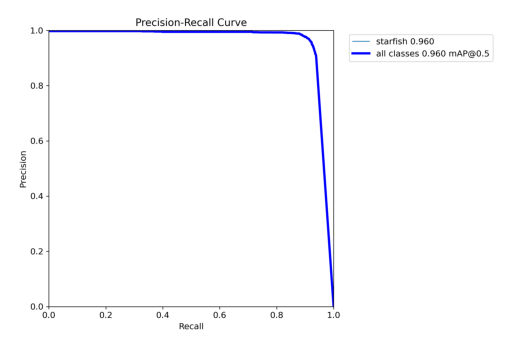

In [18]:
# plots results for yolov5l

rec_pre = Image.open(r"./runs/detect/train - v5 - optim/PR_curve.png")
fig, ax = plt.subplots()
ax.imshow(rec_pre)
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

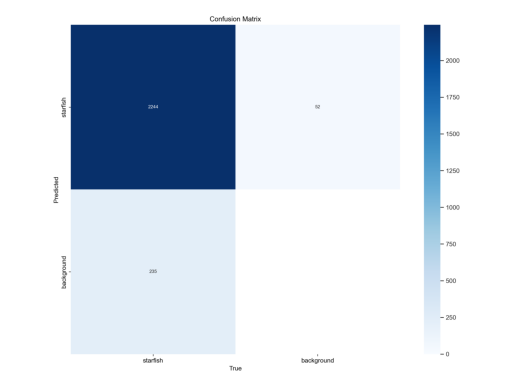

In [19]:
conf_mat = Image.open(r"./runs/detect/train - v5 - optim/confusion_matrix.png")
fig, ax = plt.subplots()
ax.imshow(conf_mat)
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

C:\Users\Itai\AppData\Local\Temp\ipykernel_17116\2381029206.py:14: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



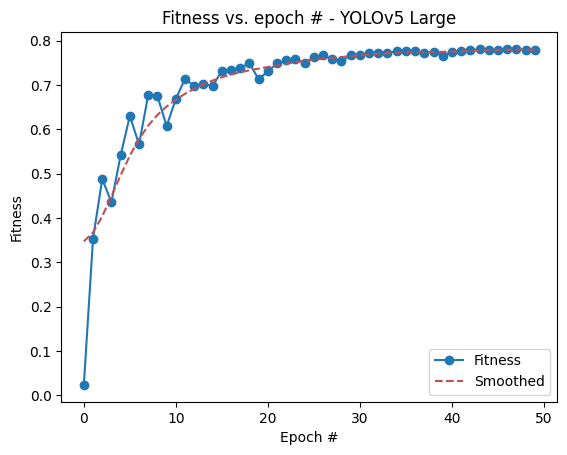

In [21]:
results_l = pd.read_csv(r"./runs/detect/train - v5 - optim/results.csv")
recall = results_l[results_l.axes[1][5]] 
map50 = results_l[results_l.axes[1][6]]
map5095 = results_l[results_l.axes[1][7]]
fitness_l = 0.2 * recall + 0.2 * map50 + 0.6 * map5095
fitness_smoothed_l = gaussian_filter1d(fitness_l, sigma=3) # Create a smoothed version of the training process
fig, ax = plt.subplots()
plt.plot(fitness_l, "-o", label="Fitness")
plt.plot(fitness_smoothed_l, "r--", label="Smoothed")
plt.title("Fitness vs. epoch # - YOLOv5 Large")
plt.xlabel("Epoch #")
plt.ylabel("Fitness")
plt.legend()
fig.show()